In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import bayes3d as b3d
import trimesh
import os
from bayes3d._mkl.utils import *
import matplotlib.pyplot as plt
import numpy as np
import jax
from jax import jit, vmap
import jax.numpy as jnp


key = jax.random.PRNGKey(0)

In [3]:
import traceviz.client
import numpy as np
from traceviz.proto import  viz_pb2

In [4]:
from typing import Any, NamedTuple


Array = np.ndarray | jax.Array
Shape = int | tuple[int, ...]
FaceIndex = int
Array3 = np.ndarray
Array2 = np.ndarray
ArrayNx2 = Array
ArrayNx3 = Array

In [5]:
def barycentric_to_mesh(p:Array3, i:FaceIndex, vertices:ArrayNx3, faces:ArrayNx3):
    x = jnp.sum(p[:,None]*vertices[faces[i]], axis=0)
    return x


def area_of_triangle(a:Array3, b:Array3, c:Array3=jnp.zeros(3)):

    v = a-c
    w = b-c

    l = jnp.linalg.norm(w)
    h = jnp.linalg.norm(v - jnp.dot(v, w)/l**2*w)
    area = l*h

    return area/2


def _compute_area_and_normal(f, vertices):
    a = vertices[f[1]] - vertices[f[0]]
    b = vertices[f[2]] - vertices[f[0]]
    area = area_of_triangle(a, b)
    normal = jnp.cross(a,b)
    return area, normal


compute_area_and_normals = jit(vmap(_compute_area_and_normal, (0,None)))

In [6]:
def patch_trimesh(mesh:trimesh.base.Trimesh):
    """
    Return a patched copy of a trimesh object, and 
    ensure it to have a texture and the following attributes:
    - `mesh.visual.uv`
    - `copy.visual.material.to_color`
    """
    patched_mesh = mesh.copy()
    if isinstance(mesh.visual, trimesh.visual.color.ColorVisuals):
        patched_mesh.visual = mesh.visual.to_texture()
    elif isinstance(mesh.visual, trimesh.visual.texture.TextureVisuals):
        pass

    return patched_mesh


def texture_uv_basis(face_idx:Array, mesh):
    return mesh.visual.uv[mesh.faces[face_idx]]


def uv_to_color(uv:ArrayNx2, mesh):
    return mesh.visual.material.to_color(uv)

In [27]:
def uniformly_sample_from_mesh(key, n, mesh, with_color=True):
    """Uniformly sample `n` points and their color on the surface from a mesh."""
    key, keys = keysplit(key,1,2)

    areas, _ = compute_area_and_normals(mesh.faces, mesh.vertices)

    # First sample face indices, then sample barycentric coordinates, and
    # finally compute the positions of the points.
    fs = jax.random.categorical(keys[0], jnp.log(areas), shape=(n,))
    ps = jax.random.dirichlet(keys[1], jnp.ones(3), (n,)).reshape((n,3,1))
    xs = jnp.sum(ps*mesh.vertices[mesh.faces[fs]], axis=1)

    if with_color:
        uvs = jnp.sum(ps* texture_uv_basis(fs, mesh), axis=1)
        cs  = uv_to_color(uvs, mesh)/255
    else:
        cs = jnp.full((n,3), 0.5)

    return xs, cs, {"barycentric": ps, "face_idx": fs}

In [13]:
import numpy as np
import trimesh

def covariance_decomposition(Cov):
    """Returns scales and rotation matrix for a covariance matrix."""
    lambdas, Q = jnp.linalg.eig(Cov)
    return jnp.sqrt(lambdas), Q


In [169]:
# def uniformly_sample_from_mesh(key, n, faces, vertices, texture_uv=None, uv_to_color=None):
#     """Uniformly sample points on the surface from a mesh."""

#     key, keys = keysplit(key,1,2)

#     areas, _ = compute_area_and_normals(faces, vertices)

#     fs = jax.random.categorical(keys[0], jnp.log(areas), shape=(n,))
#     ps = jax.random.dirichlet(keys[1], jnp.ones(3), (n,))
#     xs = jnp.sum(ps[:,:,None]*vertices[faces[fs]], axis=1)

#     if uv_to_color is not None:
#         us = jnp.sum(ps[:,:,None]*texture_uv[faces[fs]], axis=1)
#         cs = uv_to_color(us)/255
#     else:
#         cs = None

#     return xs, cs, {"barycentric": ps, "face_idx": fs}

https://sketchfab.com/search?features=animated&q=tree&type=models
https://sketchfab.com/3d-models/rigged-animated-cinematic-quality-tree-4-544329bb254d4e45b5eae96ccc5bacf6

In [170]:
!pwd

E1114 15:38:06.379257753  706942 backup_poller.cc:127]                 Run client channel backup poller: UNKNOWN:pollset_work {created_time:"2023-11-14T15:38:06.37898082+00:00", children:[UNKNOWN:Bad file descriptor {syscall:"epoll_wait", os_error:"Bad file descriptor", errno:9, created_time:"2023-11-14T15:38:06.378896903+00:00"}]}
/home/mirko/workspace/bayes3d/scripts/_mkl/notebooks


## Load Mesh

In [14]:
t=0
mesh = trimesh.load(f"data/flag_objs/flag_t_{t}.obj")

In [15]:
_scaling  = 1e-3
model_dir = os.path.join(b3d.utils.get_assets_dir(),"bop/ycbv/models")

_meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    mesh = trimesh.load(mesh_path)
    mesh.vertices *= _scaling 
    _meshes.append(mesh)


mesh_path = os.path.join(b3d.utils.get_assets_dir(), "sample_objs/cube.obj")
mesh = trimesh.load(mesh_path)
mesh.vertices *= 1e-1
_meshes.append(mesh)


In [21]:
mesh = _meshes[16] # banana 9, scissors 16

## Vis

In [22]:
mesh = patch_trimesh(mesh)

mesh.vertices.shape, mesh.faces.shape, mesh.visual.uv.shape, mesh.visual.uv[mesh.faces[:2]].shape

((8628, 3), (15728, 3), (8628, 2), (2, 3, 2))

In [18]:
areas, normals = compute_area_and_normals(mesh.faces, mesh.vertices)
areas = jnp.where(jnp.isnan(areas), 0.0, areas)
print(f"""
    mean  area: {areas.mean():0.2e}
    std   area: {areas.std():0.2e}
    total area: {areas.sum():0.4f}
    
""")


    mean  area: 1.05e-06
    std   area: 3.23e-07
    total area: 0.0165
    



In [201]:
# us_ = texvis.uv
# cs_ = texvis.material.to_color(us_)/255


# # ================================
# fig, axs = plt.subplots(1,3, figsize=(16,8))
# for ax in axs: ax.set_aspect(1)
# axs[0].scatter(*us_.T, c="b", s=1)
# axs[1].scatter(*us.T, c=cs, s=1)
# axs[2].scatter(*us_.T, c=cs_, s=1)

In [203]:
# import numpy as np
# import trimesh

# def create_ellipsoid_trimesh(covariance_matrix, num_points=10, scale=0.02):
#     # Create a sphere
#     u = np.linspace(0, 2 * np.pi, num_points)
#     v = np.linspace(0, np.pi, num_points)
#     x = np.outer(np.cos(u), np.sin(v))
#     y = np.outer(np.sin(u), np.sin(v))
#     z = np.outer(np.ones(np.size(u)), np.cos(v))

#     # Transform the sphere to the ellipsoid
#     sigma, U = np.linalg.eig(covariance_matrix)
#     D = np.diag(np.sqrt(sigma))
#     ellipsoid = U @ D @ np.linalg.inv(U) @ np.vstack([x.flatten(), y.flatten(), z.flatten()])

#     # Reshape the ellipsoid to match the shape of the original sphere vertices
#     ellipsoid = ellipsoid.T.reshape(num_points, num_points, 3)

#     # Create mesh data
#     mesh_vertices = scale*ellipsoid.reshape(-1, 3)
#     mesh_faces = []
#     for i in range(num_points - 1):
#         for j in range(num_points - 1):
#             v1 = i * num_points + j
#             v2 = v1 + 1
#             v3 = (i + 1) * num_points + j
#             v4 = v3 + 1
#             mesh_faces.append([v1, v2, v3])
#             mesh_faces.append([v2, v4, v3])

#     mesh_faces = np.array(mesh_faces)

#     # Create a trimesh object
#     trimesh_mesh = trimesh.Trimesh(vertices=mesh_vertices, faces=mesh_faces)

#     return trimesh_mesh


In [28]:
key = keysplit(key)
n = 20_000
xs, cs, _ = uniformly_sample_from_mesh(key, n, mesh, with_color=True)

# xs = np.array(xs)
# cs = np.array(cs)
# np.min(xs, axis=0), np.max(xs, axis=0)

(20000, 3, 1) (20000, 3, 2)


ValueError: Incompatible shapes for broadcasting: shapes=[(20000, 3, 1, 1), (20000, 3, 2)]

In [ ]:
# key = keysplit(key)
# xs, cs, _ = uniformly_sample_from_mesh(key, 30_000, mesh.faces, mesh.vertices, 
#                 texture_uv=texvis.uv, uv_to_color=texvis.material.to_color)

# xs = np.array(xs)
# cs = np.array(cs)
# np.min(xs, axis=0), np.max(xs, axis=0)

(array([-1.5116627 , -1.315575  , -0.48758227], dtype=float32),
 array([1.2810575 , 0.99864995, 0.3267756 ], dtype=float32))

In [207]:
 import numpy as np
from sklearn.mixture import GaussianMixture

key = keysplit(key)
# sig = 0.0; 
n_components = 50
means_init = np.array(uniformly_sample_from_mesh(key, n_components, mesh, with_color=False)[0]);
sig = 2*1e-2;
X = xs + np.random.randn(*xs.shape)*sig
# gm = GaussianMixture(n_components=n_components, tol=1e-3, max_iter=100, covariance_type="spherical").fit(X)
gm = GaussianMixture(n_components=n_components, tol=1e-3, max_iter=100, covariance_type="full", means_init=means_init).fit(X)
gm.means_.shape
vs = gm.score_samples(X)

gm.converged_

True

In [208]:
def get_mean_colors(xs, cs, labels):
    mean_colors = []
    for label in np.unique(labels):
        idx = labels == label
        mean_colors.append(np.mean(cs[idx], axis=0))
    return np.array(mean_colors)
    

In [209]:
mean_colors = get_mean_colors(xs, cs, gm.predict(X))

In [210]:
labels = gm.predict(X)
mus  = gm.means_
covs = gm.covariances_
cols = []
nums = []
for i in range(len(mus)):
    num = np.sum(labels==i)
    nums.append(num)
    cols.append(
        np.mean(cs[labels==i], axis=0) if num > 0 else np.array([0,0,0,0])
        # cs[labels==i][np.random.randint(0, len(cs[labels==i]))] if num > 0 else np.array([0,0,0,0])
    )
cols = np.array(cols)
nums = np.array(nums) > 0 
cols.shape, np.sum(nums)

((50, 4), 50)

In [211]:
def gaussian_mesh(mu=np.zeros(3), cov=np.eye(3), scale=2.0, num_points=20, color=None):
    if len(cov.shape) == 0: cov =  cov*jnp.eye(3)
    mesh = create_ellipsoid_trimesh(cov, num_points, scale)
    mesh.vertices += mu
    if color is not None: mesh.visual.face_colors = col
    return mesh


In [212]:
gm.covariances_.shape
cov_meshes = []
for i, (mu, cov, col) in enumerate(zip(mus[nums], covs[nums], cols[nums])):
    print(i, end="\r")
    cov_meshes.append(gaussian_mesh(mu,cov, scale=2., num_points=20, color=col))

len(cov_meshes), cols.shape
cols = cols[nums]

In [213]:
# scene = trimesh.Scene(cov_meshes, lights=[ trimesh.scene.lighting.DirectionalLight(color=np.array([0.5,0.1,0.1]), intensity=50.0, radius=100)])
# scene.show()


In [214]:
def split_into_vfc(cov_meshes, cols, alpha=1.0):
    vv = []
    cc = []
    ff = []
    for m,c in zip(cov_meshes, cols):
        vv.append(np.array(m.vertices))
        ff.append(np.array(m.faces)[:])
        cc.append(np.array([*c[:3], alpha]))

    vv = np.array(vv)
    cc = np.array(cc)
    ff = np.array(ff, dtype=np.int32)
    return vv, ff, cc

In [215]:
# vv = []
# cc = []
# ff = []
# for m,c in zip(cov_meshes, cols):
#     vv.append(np.array(m.vertices))
#     ff.append(np.array(m.faces)[:])
#     cc.append(np.array([*c[:3], 1.]))

# vv = np.array(vv)
# cc = np.array(cc)
# ff = np.array(ff, dtype=np.int32)
# vv.shape, cc.shape, ff.shape



In [216]:
import json

In [217]:
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg([]))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


response:  


In [218]:
vv, ff, cc = split_into_vfc(cov_meshes, cols, alpha=1.)

In [219]:
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "Gaussians"})
msg.payload.data.MergeFrom(
    traceviz.client.to_pytree_msg({'vertices': vv, 'colors': cc, "faces": ff})
)
    
    # , 'faces': mesh.faces, 'colors': cs}))

stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


response:  listener_identifiers: "2023-11-14T16:38:00.635109 :: ipv4:127.0.0.1:48962"



In [61]:
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg([]))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


response:  listener_identifiers: "2023-11-14T12:34:12.732706 :: ipv4:127.0.0.1:60350"



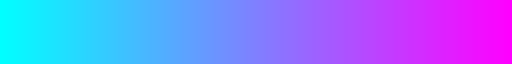

In [58]:


cm  = getattr(plt.cm, "cool")
# cs  = cm(plt.Normalize()(vs_))
cm

In [59]:
key = keysplit(key)
xs_, cs_, _ = uniformly_sample_from_mesh(key, 15_000, mesh.faces, mesh.vertices, 
                texture_uv=texvis.uv, uv_to_color=texvis.material.to_color)

# labels_ = gm.predict(xs_)
# cols_ = mean_colors[labels_]
# cs_.shape, cols_.shape



# distances = np.linalg.norm(cs_ - cols_, axis=1)
# print(distances.shape)
# print(np.min(distances), np.max(distances))
# cs_  = cm(plt.Normalize()(distances))
# cs_.shape

In [60]:


print(xs_.shape, cs_.shape)


msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "Spheres"})
msg.payload.data.MergeFrom(
    traceviz.client.to_pytree_msg({
        'centers': np.array(xs_), 
        'colors': np.array(cs_), 
        "scales": 0.025*np.ones(len(xs_))
    })
)
    

stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


(15000, 3) (15000, 4)
response:  listener_identifiers: "2023-11-14T12:34:12.732706 :: ipv4:127.0.0.1:60350"

